# NBA Game Prediction Model

This notebook implements machine learning models to predict NBA game outcomes using historical game data and advanced statistics.

## Data Pipeline

### Initial Setup
Required libraries and configurations for data processing and model training.

In [1]:
# Standard libraries
import warnings
import joblib
import json

# Data analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKeras

# Data preprocessing & evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,f1_score,recall_score,precision_score,roc_auc_score,log_loss,brier_score_loss,confusion_matrix)
from sklearn import set_config

# Machine learning models
from xgboost import XGBClassifier

# Deep learning (Keras / TensorFlow)
from keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Custom modules
from calculations import scrap_games

warnings.filterwarnings('ignore')

### Data Loading and Initial Preprocessing

Loading historical NBA game data from CSV

In [ ]:
df = pd.read_csv('game.csv')

Adding current season's games through web scraping and merging data into one data frame

In [ ]:
df2 = scrap_games()
df2['game_id'] = df2['game_id'].astype(int)
df = pd.concat([df,df2])
df = df.drop_duplicates(subset=['game_id'])
df = df.reset_index(drop=True)

In [4]:
df.head()

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
0,21946,1610610035,HUS,Toronto Huskies,24600001,1946-11-01 00:00:00,HUS vs. NYK,L,0.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,2.0,0.0,Regular Season
1,21946,1610610034,BOM,St. Louis Bombers,24600003,1946-11-02 00:00:00,BOM vs. PIT,W,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,25.0,51.0,-5.0,0.0,Regular Season
2,21946,1610610032,PRO,Providence Steamrollers,24600002,1946-11-02 00:00:00,PRO vs. BOS,W,0.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,53.0,-6.0,0.0,Regular Season
3,21946,1610610025,CHS,Chicago Stags,24600004,1946-11-02 00:00:00,CHS vs. NYK,W,0.0,21.0,...,NaN,NaN,NaN,NaN,NaN,22.0,47.0,-16.0,0.0,Regular Season
4,21946,1610610028,DEF,Detroit Falcons,24600005,1946-11-02 00:00:00,DEF vs. WAS,L,0.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,50.0,17.0,0.0,Regular Season


In [5]:
df.tail()

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
66867,22024,1610612761,TOR,Toronto Raptors,22400067,2024-10-23 00:00:00,TOR vs. CLE,L,NaN,36.0,...,36.0,29.0,10.0,9.0,12.0,22.0,136.0,30.0,NaN,NaN
66868,22024,1610612765,DET,Detroit Pistons,22400063,2024-10-23 00:00:00,DET vs. IND,L,NaN,38.0,...,39.0,32.0,10.0,8.0,15.0,23.0,115.0,6.0,NaN,NaN
66869,22024,1610612757,POR,Portland Trail Blazers,22400072,2024-10-23 00:00:00,POR vs. GSW,L,NaN,36.0,...,57.0,38.0,13.0,5.0,17.0,27.0,140.0,36.0,NaN,NaN
66870,22024,1610612747,LAL,Los Angeles Lakers,22400062,2024-10-22 00:00:00,LAL vs. MIN,W,NaN,42.0,...,47.0,17.0,4.0,1.0,15.0,22.0,103.0,-7.0,NaN,NaN
66871,22024,1610612738,BOS,Boston Celtics,22400061,2024-10-22 00:00:00,BOS vs. NYK,W,NaN,48.0,...,34.0,20.0,2.0,3.0,11.0,12.0,109.0,-23.0,NaN,NaN


Removing unnecessary columns

In [6]:
df = df.drop(columns=['video_available_home', 'video_available_away', 'min','season_type'])

Handling missing values

In [7]:
df.isna().sum()
df.dropna(inplace=True)

### Feature Engineering

Transforming the game data into separate home and away perspectives, renaming columns for consistency and adding an is_home indicator. Mapping win/loss outcomes to binary values and prepares the data for further analysis.

In [8]:
def transform_to_home_away_info(df):
    # Select columns related to home and away teams, including shared game metadata
    home_columns = [col for col in df.columns if '_home' in col or col in ['team_id_home', 'team_name_home', 'game_id', 'game_date', 'pts_away', 'season_id']]
    away_columns = [col for col in df.columns if '_away' in col or col in ['team_id_away', 'team_name_away', 'game_id', 'game_date', 'pts_home', 'season_id']]

    # Create separate DataFrames for home and away teams
    df_home = df[home_columns].copy()
    df_away = df[away_columns].copy()

    # Remove '_home'/'_away' suffixes and rename columns for consistency
    df_home.columns = df_home.columns.str.replace('_home', '')
    df_home.rename(columns={'team_id_home': 'team_id', 'team_name_home': 'team_name', 'pts_away': 'pts_lost'}, inplace=True)
    
    df_away.columns = df_away.columns.str.replace('_away', '')
    df_away.rename(columns={'team_id_away': 'team_id', 'team_name_away': 'team_name', 'pts_home': 'pts_lost'}, inplace=True)

    # Add a flag indicating whether the team was playing at home
    df_home['is_home'] = 1
    df_away['is_home'] = 0

    # Combine both DataFrames into a single one
    df_combined = pd.concat([df_home, df_away], ignore_index=True)
    
    # Convert win/loss indicators from 'W'/'L' to binary values: 1 for win, 0 for loss
    df_combined['wl'] = df_combined['wl'].map({'W': 1, 'L': 0})

    # Convert game_date to datetime format
    df_combined['game_date'] = pd.to_datetime(df_combined['game_date'])

    return df_combined

# Apply transformation to the DataFrame
df = transform_to_home_away_info(df)
df.head(5)


,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,fgm,fga,...,reb,ast,stl,blk,tov,pf,pts,plus_minus,pts_lost,is_home
0,41979,1610612747,LAL,Los Angeles Lakers,47900044,1980-05-07,LAL vs. PHL,0,48.0,95.0,...,52.0,32.0,12.0,7.0,26.0,27.0,104.0,-3.0,107.0,1
1,41979,1610612755,PHL,Philadelphia 76ers,47900045,1980-05-10,PHL vs. LAL,0,45.0,93.0,...,37.0,34.0,12.0,8.0,13.0,25.0,101.0,-10.0,111.0,1
2,41979,1610612755,PHL,Philadelphia 76ers,47900048,1980-05-16,PHL vs. LAL,0,47.0,89.0,...,36.0,27.0,4.0,11.0,18.0,27.0,107.0,-16.0,123.0,1
3,31979,1610616833,EST,East NBA All Stars East,37900001,1980-02-03,EST vs. WST,1,58.0,124.0,...,62.0,34.0,20.0,9.0,30.0,30.0,144.0,8.0,136.0,1
4,41980,1610612738,BOS,Boston Celtics,48000048,1981-05-05,BOS vs. HOU,1,41.0,95.0,...,54.0,23.0,6.0,5.0,19.0,21.0,98.0,3.0,95.0,1


In [9]:
print(df[['team_id','team_name']].sort_values(by='team_id').drop_duplicates(subset=['team_id']))

          team_id                 team_name
82609          41  Tel Aviv Maccabi Electra
26867          45          China Team China
78434          93       Haifa Maccabi Haifa
36695          94     Milano Olimpia Milano
78510          95      Vitoria Caja Laboral
...           ...                       ...
4465   1610612764        Washington Bullets
56563  1610612765           Detroit Pistons
94503  1610612766         Charlotte Hornets
36880  1610616833   East NBA All Stars East
9612   1610616834   West NBA All Stars West

[67 rows x 2 columns]


Computing advanced basketball statistics for each game, such as possessions, offensive/defensive ratings, effective field goal percentage, true shooting percentage, and other metrics to enhance predictive modeling.

In [10]:
def calculate_advanced_stats(df):
    df['possessions'] = df['fga'] - df['oreb'] + df['tov'] + 0.44 * df['fta']
    df['ORTG'] = df['pts'] / df['possessions']
    df['DRTG'] = df['pts_lost'] / df['possessions']
    df['eFG%'] = (df['fgm'] + 0.5 * df['fg3m']) / df['fga']
    df['TS%'] = df['pts'] / (2 * (df['fga'] + 0.44 * df['fta']))
    df['AST%'] = df['ast'] / df['fgm']
    df['PF%'] = df['pf'] / (df['possessions'])
    df['TOV%'] = df['tov'] / df['possessions']
    df['FTR'] = df['fta'] / df['fga']
    df['PPS'] = df['pts'] / df['fga']
    df['3PAr'] = df['fg3a'] / df['fga']
    return df
df = calculate_advanced_stats(df)
df.head(5)

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,fgm,fga,...,ORTG,DRTG,eFG%,TS%,AST%,PF%,TOV%,FTR,PPS,3PAr
0,41979,1610612747,LAL,Los Angeles Lakers,47900044,1980-05-07,LAL vs. PHL,0,48.0,95.0,...,0.934579,0.961538,0.505263,0.518548,0.666667,0.242631,0.233645,0.126316,1.094737,0.010526
1,41979,1610612755,PHL,Philadelphia 76ers,47900045,1980-05-10,PHL vs. LAL,0,45.0,93.0,...,1.005175,1.104697,0.489247,0.502588,0.755556,0.248806,0.129379,0.182796,1.086022,0.043011
2,41979,1610612755,PHL,Philadelphia 76ers,47900048,1980-05-16,PHL vs. LAL,0,47.0,89.0,...,0.975565,1.121444,0.528090,0.542156,0.574468,0.246171,0.164114,0.247191,1.202247,0.067416
3,31979,1610616833,EST,East NBA All Stars East,37900001,1980-02-03,EST vs. WST,1,58.0,124.0,...,1.011520,0.955325,0.471774,0.502232,0.586207,0.210733,0.210733,0.354839,1.161290,0.016129
4,41980,1610612738,BOS,Boston Celtics,48000048,1981-05-05,BOS vs. HOU,1,41.0,95.0,...,1.002045,0.971370,0.431579,0.472062,0.560976,0.214724,0.194274,0.210526,1.031579,0.010526


Spliting the DataFrame by season and applies a provided function to each season's data, then recombines the results. Useful for season-specific calculations while maintaining data integrity.

In [11]:
def season_split(df, func):    
    unique_seasons = df['season_id'].unique()
    
    modified_frames = []
    
    for season in unique_seasons:
        subframe = df[df['season_id'] == season].copy()
        modified_subframe = func(subframe)
        modified_frames.append(modified_subframe)
        
    df = pd.concat(modified_frames, ignore_index=True)
    return df

Calculating the cumulative win/loss ratio for each team by sorting games chronologically and tracking wins and games played, providing a measure of team performance over time.

In [12]:
def calculate_win_loss_ratio(df):
    df = df.sort_values(by=['team_id', 'game_date']).copy()
    df['wins'] = (df.groupby('team_id')['wl'].transform(lambda group: group.shift(1).cumsum()))
    df['games'] = (df.groupby('team_id')['wl'].transform(lambda group: group.shift(1).expanding().count()))
    df['win_loss_ratio'] = df['wins'] / df['games'].replace(0, np.nan)
    df = df.drop(columns=['games', 'wins'])
    return df


df = season_split(df, calculate_win_loss_ratio)
df.head(5)

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,fgm,fga,...,DRTG,eFG%,TS%,AST%,PF%,TOV%,FTR,PPS,3PAr,win_loss_ratio
0,41979,1610612747,LAL,Los Angeles Lakers,47900044,1980-05-07,LAL vs. PHL,0,48.0,95.0,...,0.961538,0.505263,0.518548,0.666667,0.242631,0.233645,0.126316,1.094737,0.010526,NaN
1,41979,1610612747,LAL,Los Angeles Lakers,47900045,1980-05-10,LAL @ PHL,1,44.0,92.0,...,0.978682,0.478261,0.527567,0.454545,0.242248,0.193798,0.326087,1.206522,0.010870,0.0
2,41979,1610612747,LAL,Los Angeles Lakers,47900048,1980-05-16,LAL @ PHL,1,45.0,92.0,...,0.996276,0.489130,0.572626,0.600000,0.204842,0.158287,0.380435,1.336957,0.021739,0.5
3,41979,1610612755,PHL,Philadelphia 76ers,47900044,1980-05-07,PHL @ LAL,1,43.0,85.0,...,0.929567,0.505882,0.552230,0.790698,0.187701,0.178763,0.317647,1.258824,0.011765,NaN
4,41979,1610612755,PHL,Philadelphia 76ers,47900045,1980-05-10,PHL vs. LAL,0,45.0,93.0,...,1.104697,0.489247,0.502588,0.755556,0.248806,0.129379,0.182796,1.086022,0.043011,1.0


Computing rolling averages for key statistics over short-term (5 games) and long-term (15 games) windows, dropping raw stats to focus on averaged metrics for predictive consistency.

In [13]:
def avg_calc(df):
    df_copy = df.copy()
    
    stats_columns = ['wl','fga', 'fg_pct', 'fg3a', 'fg3_pct', 'fgm', 'fg3m', 'ftm','dreb','plus_minus',
                     'fta', 'ft_pct','oreb', 'reb', 'ast', 'stl', 'blk', 
                     'tov', 'pf', 'pts','pts_lost', 'possessions', 'ORTG', 
                     'DRTG', 'eFG%', 'TS%', 'AST%', 'PF%','TOV%', 'FTR', 'PPS', 
                     '3PAr']

    rolling_windows = {
        "ShortTerm": (5, 1),
        "LongTerm": (15, 1)
    }

    for name, (window, min_periods) in rolling_windows.items():
        avg_stats = (
            df.groupby('team_id')[stats_columns]
            .apply(lambda group: group.shift(1).rolling(window=window, min_periods=min_periods).mean())
            .reset_index(level=0, drop=True)
        )
        df_copy = pd.concat([df_copy, avg_stats.add_suffix(f'_avg_{name}')], axis=1)
    
    columns_to_drop = ['fga', 'fg_pct', 'fg3a', 'fg3_pct', 'fgm', 'fg3m', 'ftm','dreb','plus_minus',
                     'fta', 'ft_pct','oreb', 'reb', 'ast', 'stl', 'blk', 
                     'tov', 'pf', 'pts','pts_lost', 'possessions', 'ORTG', 
                     'DRTG', 'eFG%', 'TS%', 'AST%', 'PF%','TOV%', 'FTR', 'PPS', 
                     '3PAr']    
    df_copy = df_copy.drop(columns=columns_to_drop)

    return df_copy

df = season_split(df,avg_calc)
df.head(5)
df = df.sort_values(by=['game_id']).reset_index(drop=True)

Creating home-team and away-team perspective DataFrame by merging home and away game data, renaming columns to reflect opponent stats.

In [14]:
def home_away(df):
    home_df = df[df['is_home'] == 1].add_suffix('_home')
    away_df = df[df['is_home'] == 0].add_suffix('_away')
    home_away = pd.merge(
        home_df, away_df, 
        left_on='game_id_home', right_on='game_id_away', 
        suffixes=('_home', '_away')
    )
    return home_away

def away_home(df):
    home_df = df[df['is_home'] == 1].add_suffix('_home')
    away_df = df[df['is_home'] == 0].add_suffix('_away')
    away_home = pd.merge(
        away_df, home_df, 
        left_on='game_id_away', right_on='game_id_home', 
        suffixes=('_away', '_home'))
    return away_home
home_away = home_away(df)
away_home = away_home(df)

Renaming columns in the NBA game DataFrame to standardize home and away team data.

In [15]:
def rename_columns_home_away(df):
    new_columns = {}
    for col in df.columns:
        if col.endswith('_home'):
            new_columns[col] = col.replace('_home', '')
        elif col.endswith('_away'):
            new_columns[col] = col.replace('_away', '_opp')
    return df.rename(columns=new_columns)
home_away = rename_columns_home_away(home_away)
home_away = home_away.rename(columns={'is':'is_home'})
home_away = home_away.drop(columns=['is_home_opp'])

In [16]:
def rename_columns_away_home(df):
    new_columns = {}
    for col in df.columns:
        if col.endswith('_away'):
            new_columns[col] = col.replace('_away', '')
        elif col.endswith('_home'):
            new_columns[col] = col.replace('_home', '_opp')
    return df.rename(columns=new_columns)
away_home = rename_columns_away_home(away_home)
away_home = away_home.rename(columns={'is_home_opp':'is_home'})
away_home = away_home.drop(columns=['is_opp_opp'])
home_away.head(5)

,season_id,team_id,team_abbreviation,team_name,game_id,game_date,matchup,wl,is_home,win_loss_ratio,...,ORTG_avg_LongTerm_opp,DRTG_avg_LongTerm_opp,eFG%_avg_LongTerm_opp,TS%_avg_LongTerm_opp,AST%_avg_LongTerm_opp,PF%_avg_LongTerm_opp,TOV%_avg_LongTerm_opp,FTR_avg_LongTerm_opp,PPS_avg_LongTerm_opp,3PAr_avg_LongTerm_opp
0,12005,1610612764,WAS,Washington Wizards,10500001,2005-10-10,WAS vs. CLE,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12005,1610612755,PHI,Philadelphia 76ers,10500002,2005-10-11,PHI vs. HOU,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12005,1610612737,ATL,Atlanta Hawks,10500003,2005-10-11,ATL vs. ORL,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12005,1610612765,DET,Detroit Pistons,10500004,2005-10-11,DET vs. CHI,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12005,1610612758,SAC,Sacramento Kings,10500005,2005-10-11,SAC vs. DAL,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Displaying the differences in column names between home_away and away_home DataFrames.

In [17]:
print(f"{set(list(home_away.columns)) - set(away_home.columns)}")
print(f"{set(list(away_home.columns)) - set(home_away.columns)}")

set()
set()


Calculating Elo ratings for teams based on game outcomes, updating ratings after each game using expected probabilities and a k-factor to reflect performance changes.

In [18]:
def elo_calc(df, initial_elo=1500, k_factor=40): 
    df = df.sort_values(by='game_date').reset_index(drop=True)
    elo_ratings = {}
    home_elos, away_elos = [], []

    for _, row in df.iterrows():
        team = row['team_name']
        team_opp = row['team_name_opp']

        home_elo = elo_ratings.get(team, initial_elo)
        away_elo = elo_ratings.get(team_opp, initial_elo)

        home_elos.append(home_elo)
        away_elos.append(away_elo)

        outcome = row['wl']
        expected = 1 / (1 + 10 ** ((away_elo - home_elo) / 400))
        expected_opp = 1 - expected

        elo_ratings[team] = home_elo + k_factor * (outcome - expected)
        elo_ratings[team_opp] = away_elo + k_factor * ((1 - outcome) - expected_opp)

    df['elo'] = home_elos
    df['elo_opp'] = away_elos
    df['elo_diff'] = df['elo'] - df['elo_opp']

    return df

Applying Elo calculations to home and away DataFrames, ensuring consistent Elo ratings across perspectives by transferring opponent Elo scores and computing Elo differences.

In [19]:
def add_elo_ranking(df1, df2):
    df1 = elo_calc(df1)
    df1 = df1.sort_values(by=['game_date','game_id']).reset_index(drop=True)
    df2 = df2.sort_values(by=['game_date','game_id']).reset_index(drop=True)
    df2['elo'] = df1['elo_opp']
    df2['elo_opp'] = df1['elo']
    df2['elo_diff'] = -df1['elo_diff']
    return df1, df2

home_away, away_home = add_elo_ranking(home_away,away_home)

Removing unnecessary columns

In [20]:

home_away = home_away.drop(columns = ['game_id_opp', 'game_date_opp', 'wl_opp'])
away_home = away_home.drop(columns=['game_id_opp', 'game_date_opp','wl_opp'])

Merging the two DataFrames into a final DataFrame

In [21]:
df_final = pd.concat([home_away,away_home])

Calculating differences between team and opponent statistics for specified prefixes and time horizons, adding new columns for each difference.

In [22]:
def calculate_stat_differences(df):
    df = df.sort_values(by=['game_date'])
    stats_prefixes = [
        'wl_avg', 'plus_minus_avg', 'fg_pct_avg',
        'fg3m_avg', 'fg3a_avg', 'fg3_pct_avg', 'fta_avg', 'ft_pct_avg','reb_avg', 'ast_avg',
        'tov_avg', 'pf_avg', 'pts_avg','PTS_sum', 'pts_lost_avg', 'possessions', 'ORTG', 'DRTG', 'eFG%', 'TS%', 'AST%', 'PF%',
       'TOV%', 'FTR', 'PPS', '3PAr'
    ]
    time_horizons = ['ShortTerm', 'LongTerm']
    
    for prefix in stats_prefixes:
        for horizon in time_horizons:
            home_col = f"{prefix}_{horizon}"
            opp_col = f"{prefix}_{horizon}_opp"
            
            if home_col in df.columns and opp_col in df.columns:
                diff_col_name = f"{prefix}_{horizon}_diff"
                df[diff_col_name] = df[home_col] - df[opp_col]
    
    for horizon in time_horizons:
        pts_col = f"pts_avg_{horizon}"
        pts_lost_col = f"pts_lost_avg_{horizon}"
        pts_diff_col = f"pts_diff_{horizon}"

        if pts_col in df.columns and pts_lost_col in df.columns:
            df[pts_diff_col] = df[pts_col] - df[pts_lost_col]
    
    return df

df_final = calculate_stat_differences(df_final)

Filtering games after 1990-09-01 - NBA has changed over the years, removing duplicate game entries, sorting by game date, and removing rows with missing values.

In [23]:
df_final = df_final[df_final['game_date']>'1990-09-01']
df_final = df_final.sort_values(by=['is_home'], ascending=False).reset_index(drop=True)
df_final = df_final.drop_duplicates(subset=['game_id'], keep='first')
df_final = df_final.sort_values(by = ['game_date']).reset_index(drop=True)
df_final = df_final.dropna()

Selection of features and target variable.

In [24]:
X = df_final.drop(columns=['season_id', 'team_id', 'team_abbreviation', 'team_name', 'game_id', 'game_date', 'matchup',
                            'wl','season_id_opp', 'team_id_opp', 'team_abbreviation_opp', 'team_name_opp', 'matchup_opp', 'is_home'])

y = df_final['wl']

Scaling the features to a range of 0 to 1

In [25]:
scaler = MinMaxScaler(feature_range=(0,1))

X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, 'scaler.pkl')

with open('features.json', 'w') as f:
    json.dump(X.columns.tolist(), f)

Removing redundant features using PCA

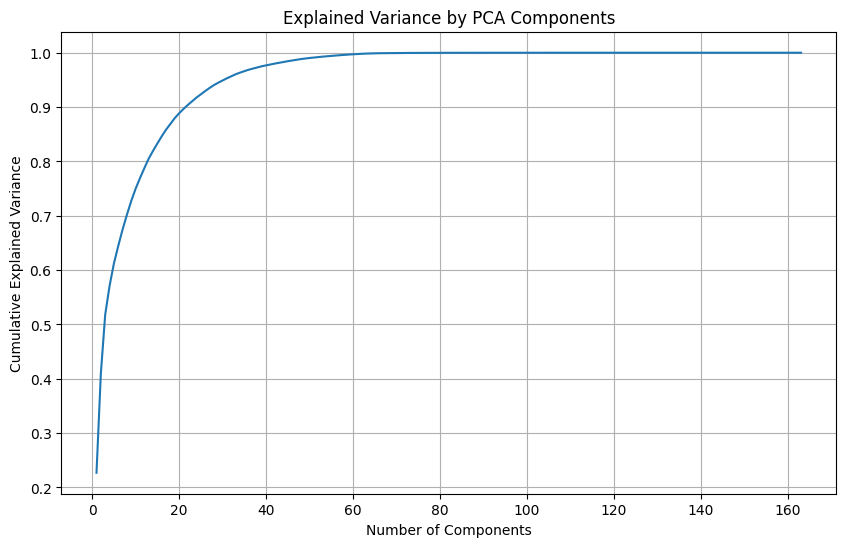

Number of components that explain 95% of the variance: 31


In [26]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

pca_95 = PCA(n_components=0.95)
X_reduced = pca_95.fit_transform(X_scaled)
joblib.dump(pca_95, 'pca.pkl')

print(f"Number of components that explain 95% of the variance: {X_reduced.shape[1]}")



## XGBClassifier

Splitting the data into training, validation, and test sets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.15, random_state=100, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=100, stratify=y_train)

Initializing an XGBoost classifier with tuned hyperparameters to predict game outcomes. The model uses 500 decision trees (n_estimators) for robust fitting, a low learning rate of 0.01 for stable convergence, and a maximum tree depth of 5 to prevent overfitting. Subsampling (80% of data) and feature sampling (70% of features) enhance generalization, while L1 (reg_alpha=0.1) and L2 (reg_lambda=10) regularization reduce model complexity. A gamma value of 1 encourages slightly deeper splits, and the logloss evaluation metric ensures optimization for probabilistic predictions. The random state is set to 100 for reproducibility.

In [28]:
model_xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=10,
    random_state=100,
    use_label_encoder=False,
    eval_metric="logloss"
)


In [29]:
set_config(display="text")

model_xgb.fit(X_train,y_train)
y_pred_prob_xgb = model_xgb.predict_proba(X_test)[:,1]


Defining a function to evaluate a binary classification model by computing multiple performance metrics, including Log Loss, Brier Score, Accuracy, F1 Score, Recall, Precision, ROC AUC, and Confusion Matrix. The function converts predicted probabilities to binary predictions using a specified threshold (default 0.5), calculates each metric, and prints the results formatted to four decimal places for numerical metrics and as a matrix for the confusion matrix. The metrics are returned as a dictionary for further use.

In [36]:
def evaluate_model(y_true, y_pred_prob, threshold=0.5):
    y_pred = (y_pred_prob > threshold).astype(int)
    metrics = {
        "Log Loss": log_loss(y_true, y_pred_prob),
        "Brier Score": brier_score_loss(y_true, y_pred_prob),
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_pred_prob),
        "Confusion Matrix": confusion_matrix(y_true, y_pred)
    }
    
    for key, value in metrics.items():
        if key == "Confusion Matrix":
            plt.figure(figsize=(8, 6))
            sns.heatmap(value, annot=True, fmt="d", cmap="coolwarm", cbar=False, 
                        xticklabels=["Predicted Negative", "Predicted Positive"],
                        yticklabels=["Actual Negative", "Actual Positive"])
            plt.title("Confusion Matrix")
            plt.ylabel("Actual")
            plt.xlabel("Predicted")
            plt.show()
        else:
            print(f"{key}: {value:.4f}")    
    return metrics

XGBoost model evaluating

Log Loss: 0.6076
Brier Score: 0.2099
Accuracy: 0.6731
F1 Score: 0.7499
Recall: 0.8244
Precision: 0.6877
ROC AUC: 0.7093


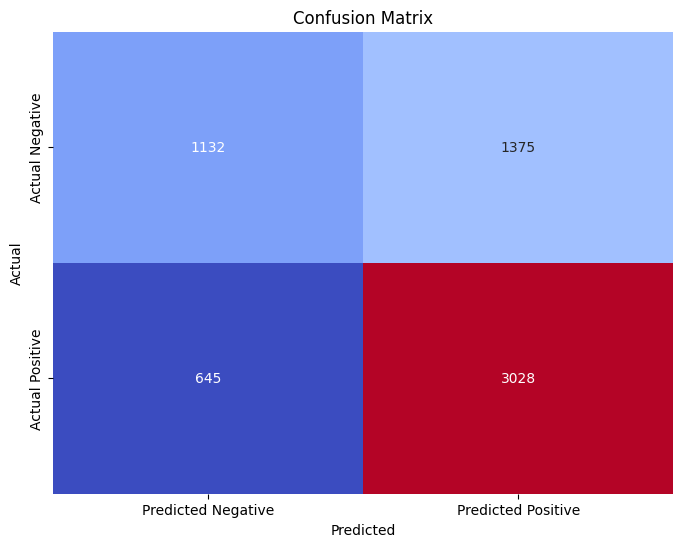

In [37]:
m = evaluate_model(y_test, y_pred_prob_xgb)

The XGBoost model achieves a Log Loss of 0.6076, indicating reasonable probability calibration, and a Brier Score of 0.2099, suggesting moderate accuracy in predicted probabilities. With an Accuracy of 67.31%, it correctly classifies over two-thirds of instances. The F1 Score (0.7499) reflects a strong balance between Precision (68.77%) and Recall (82.44%), with high Recall indicating the model excels at identifying positive cases, though Precision is slightly lower, suggesting some false positives. The ROC AUC of 0.7093 indicates decent discriminative ability. The Confusion Matrix shows 1132 true negatives, 3028 true positives, 1375 false positives, and 645 false negatives, highlighting a tendency toward false positives but strong positive class detection.

## Keras Neural Network

Defining a Keras Sequential neural network. The model begins with an InputLayer matching the feature dimension of X_train. It consists of three hidden layers: two with 64 neurons and one with 8 neurons, all using Leaky ReLU activation to handle non-linearity. Each hidden layer is followed by Dropout (0.2) to reduce overfitting and BatchNormalization to stabilize and accelerate training by normalizing activations. The output layer has a single neuron with sigmoid activation for binary predictions. The model is compiled with the Adam optimizer, binary cross-entropy loss, and tracks accuracy.

In [32]:
model_nn = Sequential()
model_nn.add(InputLayer(input_shape=(X_train.shape[1],)))
model_nn.add(Dense(64, activation='leaky_relu'))
model_nn.add(Dropout(0.2))
model_nn.add(BatchNormalization())
model_nn.add(Dense(64, activation='leaky_relu'))
model_nn.add(Dropout(0.2))
model_nn.add(BatchNormalization())
model_nn.add(Dense(8, activation='leaky_relu'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(1, activation='sigmoid'))

model_nn.compile(optimizer=Adam(), loss = 'binary_crossentropy', metrics=['accuracy'])

model_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,249 (28.32 KB)

 Trainable params: 6,993 (27.32 KB)

 Non-trainable params: 256 (1.00 KB)

Implementing early stopping to monitor validation loss, stopping training if no improvement occurs for 10 epochs and restoring the best model weights. The neural network is trained on X_train and y_train with a batch size of 16 for up to 50 epochs, using X_val and y_val for validation. The training process includes two callbacks: EarlyStopping to prevent overfitting and PlotLossesKeras to visualize training and validation loss curves in real-time, aiding in performance monitoring.

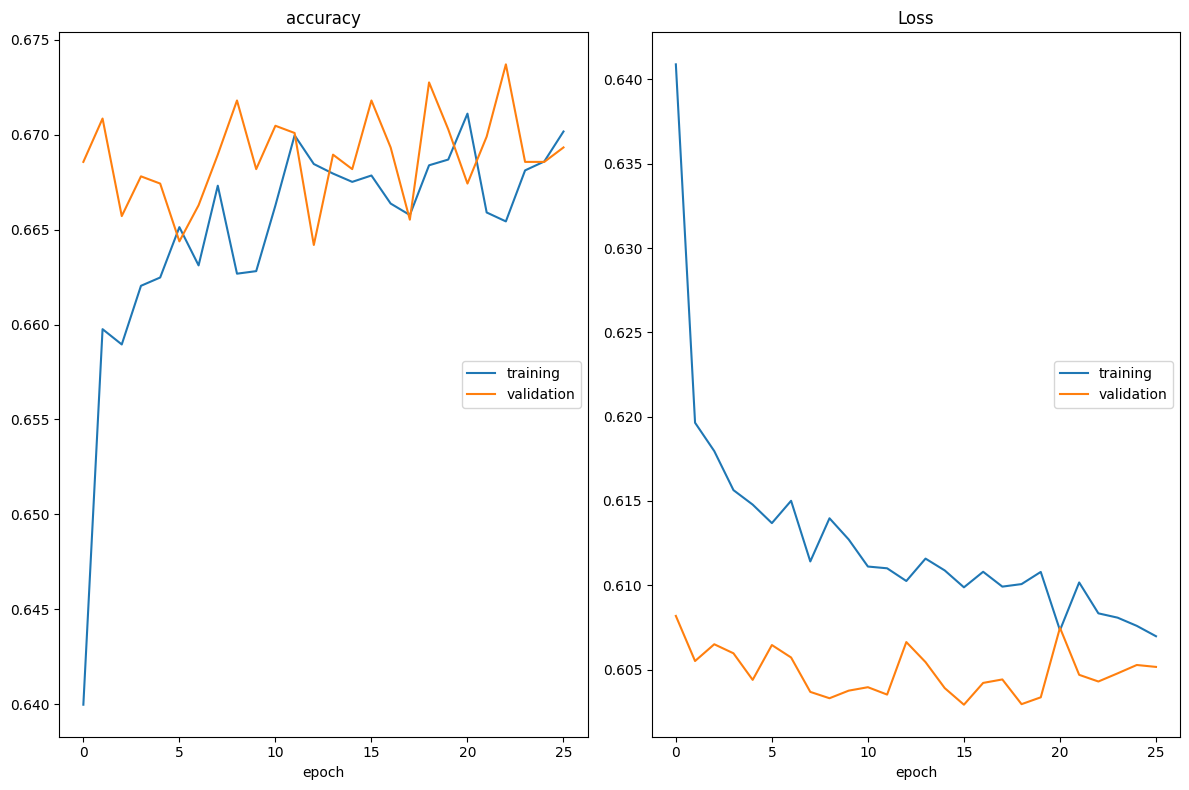

accuracy
	training         	 (min:    0.640, max:    0.671, cur:    0.670)
	validation       	 (min:    0.664, max:    0.674, cur:    0.669)
Loss
	training         	 (min:    0.607, max:    0.641, cur:    0.607)
	validation       	 (min:    0.603, max:    0.608, cur:    0.605)
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6692 - loss: 0.6071 - val_accuracy: 0.6693 - val_loss: 0.6052


In [33]:
callback = EarlyStopping(patience=10, monitor='val_loss',restore_best_weights=True)

history = model_nn.fit(X_train, y_train, batch_size=16, epochs=50, validation_data = (X_val,y_val), callbacks=[callback, PlotLossesKeras()])

Evaluating NN model

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
Log Loss: 0.6041
Brier Score: 0.2083
Accuracy: 0.6727
F1 Score: 0.7482
Recall: 0.8184
Precision: 0.6891
ROC AUC: 0.7151


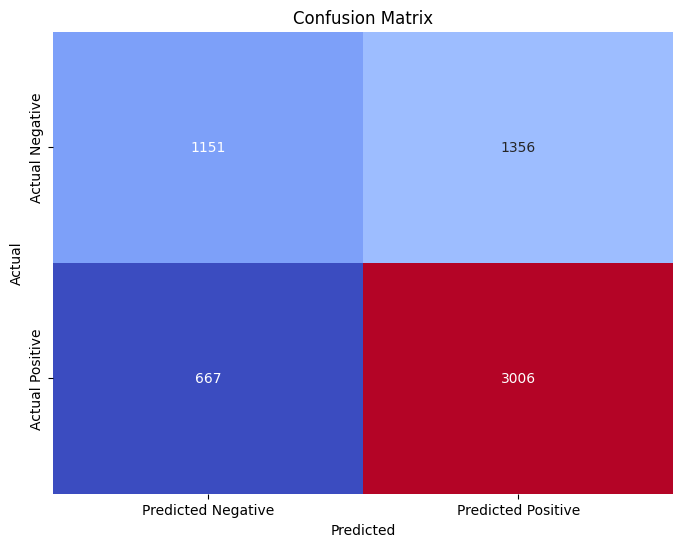

In [38]:
y_pred_nn = model_nn.predict(X_test)
m = evaluate_model(y_test, y_pred_nn)

The Keras Neural Network model performs slightly better in some metrics, with a Log Loss of 0.6041 and a Brier Score of 0.2083, indicating marginally better probability calibration than XGBoost. Its Accuracy (67.27%) is nearly identical to XGBoost. The F1 Score (0.7482) is slightly lower, driven by a Recall of 81.84% (lower than XGBoost) and a Precision of 68.91% (slightly higher). The ROC AUC of 0.7151 suggests better discriminative power than XGBoost. The Confusion Matrix reports 1151 true negatives, 3006 true positives, 1356 false positives, and 667 false negatives, showing fewer false positives but more false negatives compared to XGBoost.

Saving neural network model for predictions

In [35]:
model_nn.save('NN.keras')

## Model comparison

Both models perform similarly, with closely aligned Accuracy (~67.3%), F1 Scores (~0.75), and Brier Scores (~0.21). The Keras NN edges out slightly with a lower Log Loss (0.6041 vs. 0.6076) and higher ROC AUC (0.7151 vs. 0.7093), indicating better probability calibration and discriminative ability. However, XGBoost has a higher Recall (82.44% vs. 81.84%), making it better at capturing positive cases, which may be critical depending on the use case (e.g., prioritizing true positives). Conversely, the Keras NN has slightly better Precision (68.91% vs. 68.77%) and fewer false positives (1356 vs. 1375), which could be advantageous if minimizing incorrect positive predictions is key.